## Импорт

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from classification.MNIST.getdata import get_data
# from classification.MNIST.vis import plot_digit, plot_digits, save_fig
import models.Model as md
import models.viz as vz

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, \
    roc_curve, roc_auc_score

In [2]:
%reload_ext autoreload
%autoreload 2



## Получение данных и инициализация переменных

In [3]:
mnist = get_data()
X, y = mnist['data'], mnist['target']

In [4]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

C:\Users\Alex\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning




## Подготовка данных

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((60000, 784), (60000,), (10000, 784), (10000,))

In [10]:
(X_train, y_train)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([0., 2., 1., ..., 5., 0., 3.]))


## Обучение

### Делим метки на два класса: пятерки и не пятерки

In [11]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5
y_train_5

array([False, False, False, ...,  True, False, False])

In [26]:
sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
pipe = Pipeline([
    ('sgd', sgd_clf)
])
sgd_clf

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [13]:
scores = cross_val_score(pipe, X_train, y_train_5, cv=skfolds, scoring="accuracy")
scores

array([0.96305, 0.9638 , 0.9589 ])

In [15]:
y_train_pred = cross_val_predict(pipe, X_train, y_train_5, cv=skfolds)

conf_mat = confusion_matrix(y_train_5, y_train_pred)
ps = precision_score(y_train_5, y_train_pred)
rs = recall_score(y_train_5, y_train_pred)
fs = f1_score(y_train_5, y_train_pred)

print( y_train_pred )
md.printMetrics(ps, rs, fs, conf_mat)

[False False False ...  True False False]
Presion -  0.7930841121495327
Recall  -  0.7826969193875669
F1      -  0.787856280753876
[[53472  1107]
 [ 1178  4243]]


In [16]:
y_scores = cross_val_predict(pipe,  X_train, y_train_5, cv=skfolds, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
(y_scores, precisions, recalls, thresholds)

(array([ -54674.52564836, -498203.34917484, -662257.54844947, ...,
         145597.03176474, -591350.21672903, -669864.33868983]),
 array([0.09067037, 0.09065516, 0.09065668, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99815532e-01, 9.99815532e-01, ...,
        3.68935621e-04, 1.84467810e-04, 0.00000000e+00]),
 array([-1902371.07026052, -1901449.02319072, -1901340.56493969, ...,
          887422.0132871 ,   888728.3408757 ,   923234.26991775]))

Saving figure precision_recall_vs_threshold_plot


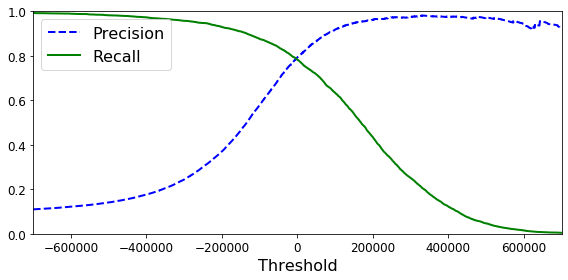

In [20]:
plt.figure(figsize=(8, 4))
vz.plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
vz.save_fig("precision_recall_vs_threshold_plot")

Saving figure precision_vs_recall_plot


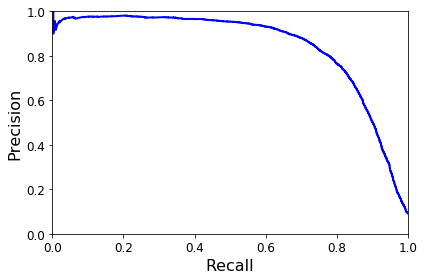

In [21]:
plt.figure(figsize=(6, 4))
vz.plot_precision_vs_recall(precisions, recalls)
vz.save_fig("precision_vs_recall_plot")

In [22]:
# Выбираем порог оценки 70000
y_train_pred_90 = (y_scores > 70000)

conf_mat = confusion_matrix(y_train_5, y_train_pred_90)
ps = precision_score(y_train_5, y_train_pred_90)
rs = recall_score(y_train_5, y_train_pred_90)
fs = f1_score(y_train_5, y_train_pred_90)

print( y_train_pred_90 )
md.printMetrics(ps, rs, fs, conf_mat)

[False False False ...  True False False]
Presion -  0.8909747292418773
Recall  -  0.6828998339789707
F1      -  0.7731829573934837
[[54126   453]
 [ 1719  3702]]


In [23]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
roc_auc_score(y_train_5, y_scores)

0.9588196762649581

Saving figure roc_curve_plot


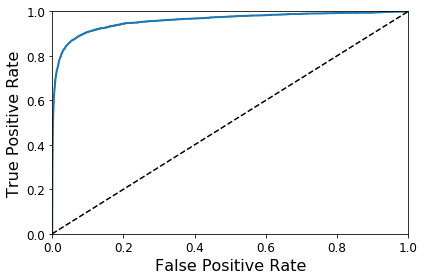

In [24]:
plt.figure(figsize=(6, 4))
vz.plot_roc_curve(fpr, tpr)
vz.save_fig("roc_curve_plot")

#### RandomForestClassifier

In [28]:
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
forest_clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [29]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

(y_probas_forest, y_scores_forest,
 fpr_forest, tpr_forest, thresholds_forest)

(array([[1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        ...,
        [0.7, 0.3],
        [1. , 0. ],
        [1. , 0. ]]),
 array([0. , 0. , 0. , ..., 0.3, 0. , 0. ]),
 array([0.00000000e+00, 5.49661958e-05, 7.32882611e-05, 2.93153044e-04,
        5.13017827e-04, 1.39247696e-03, 3.07810696e-03, 6.92574067e-03,
        1.64165705e-02, 4.46691951e-02, 1.60464648e-01, 1.00000000e+00]),
 array([0.        , 0.28979893, 0.50285925, 0.64379266, 0.75133739,
        0.82641579, 0.88452315, 0.92529054, 0.95296071, 0.97657259,
        0.99003874, 1.        ]),
 array([2. , 1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0. ]))

In [30]:
(y_probas_forest.shape, y_scores_forest.shape,
 fpr_forest.shape, tpr_forest.shape, thresholds_forest.shape)

((60000, 2), (60000,), (12,), (12,), (12,))

Saving figure roc_curve_comparison_plot


0.991298722434937

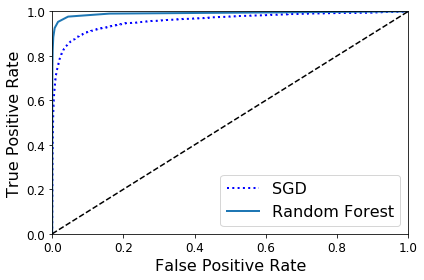

In [31]:
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
vz.plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
vz.save_fig("roc_curve_comparison_plot")

roc_auc_score(y_train_5, y_scores_forest)

In [32]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

conf_mat = confusion_matrix(y_train_5, y_train_pred_forest)
ps = precision_score(y_train_5, y_train_pred_forest)
rs = recall_score(y_train_5, y_train_pred_forest)
fs = f1_score(y_train_5, y_train_pred_forest)

print( y_train_pred_forest )
md.printMetrics(ps, rs, fs, conf_mat)

[False False False ... False False False]
Presion -  0.9833187006145742
Recall  -  0.8264157904445675
F1      -  0.8980655507667636
[[54503    76]
 [  941  4480]]



### Многоклассовая классификация

In [33]:
sgd_clf.fit(X_train, y_train)
sgd_clf.score(X_train, y_train)

0.8828166666666667

In [35]:
print(y_train[25001])
sgd_clf.predict([X_train[25001]])

9.0


array([9.])

In [51]:
some_digit = X_train[25001]
some_digit_scores = sgd_clf.decision_function([some_digit])

(some_digit.shape, some_digit_scores, np.argmax(some_digit_scores))

((784,),
 array([[-474568.983447  , -147646.25369969, -303039.20602305,
         -100617.47506935, -112266.45899881,  -90915.55627759,
         -293773.00082369, -155453.6421279 ,  -11889.94449065,
          122485.60304287]]),
 9)

In [52]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=1000,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=42, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   n_jobs=None)

In [60]:
%%time
ovo_clf.fit(X_train, y_train)
(ovo_clf.score(X_train, y_train),   ovo_clf.predict([some_digit]))

Wall time: 54 s


(0.9428166666666666, array([9.]))

In [59]:
%%time
forest_clf.fit(X_train, y_train)

(forest_clf.score(X_train, y_train),  forest_clf.predict([some_digit]),  forest_clf.predict_proba([some_digit]))

Wall time: 5.62 s


(0.9993666666666666,
 array([9.]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]))

In [61]:
(
sgd_clf.score(X_test, y_test),
ovo_clf.score(X_test, y_test),
forest_clf.score(X_test, y_test)
)

(0.8786, 0.9219, 0.9485)

In [62]:
(
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy'),
cross_val_score(ovo_clf, X_train, y_train, cv=3, scoring='accuracy'),
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring='accuracy'),\
)

(array([0.8703, 0.8688, 0.8771]),
 array([0.91645, 0.91565, 0.91455]),
 array([0.9405 , 0.93855, 0.9424 ]))

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
(scaler, X_train_scaled)

(StandardScaler(copy=True, with_mean=True, with_std=True),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [72]:
(
X_train[:4, 152:157],
X_train_scaled[:4, 152:157]
)

(array([[206, 253, 253, 254, 248],
        [253, 253, 253, 176, 110],
        [  0,  67, 194, 255, 122],
        [  0,   0, 183, 255, 136]], dtype=uint8),
 array([[ 1.53837864,  1.73840137,  1.56670239,  1.50604365,  1.47438639],
        [ 2.02991969,  1.73840137,  1.56670239,  0.78712536,  0.19534218],
        [-0.61603533, -0.06600791,  1.01615477,  1.51526056,  0.30656342],
        [-0.61603533, -0.7159833 ,  0.91351029,  1.51526056,  0.43632152]]))

In [73]:
(
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy'),
cross_val_score(ovo_clf, X_train_scaled, y_train, cv=3, scoring='accuracy'),
cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring='accuracy'),
)

(array([0.91025, 0.90815, 0.91285]),
 array([0.91345, 0.91125, 0.9169 ]),
 array([0.94055, 0.93865, 0.9424 ]))

[0. 2. 1. ... 5. 0. 3.] (60000,)
[[5746    3   18    9   10   41   43    9   40    4]
 [   1 6507   45   27    5   33    7   10   96   11]
 [  59   38 5341   96   77   24   95   59  155   14]
 [  48   44  140 5316    1  236   35   62  149  100]
 [  26   31   40   10 5362   10   54   37   78  194]
 [  71   39   31  197   71 4615  112   27  172   86]
 [  35   25   43    1   38   85 5640    5   44    2]
 [  26   24   63   22   47    9    5 5819   14  236]
 [  54  168   73  149   13  159   54   29 5017  135]
 [  45   40   31   85  158   46    2  199   81 5262]]
Saving figure confusion_matrix_plot


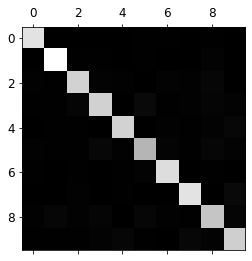

In [75]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(y_train_pred, y_train_pred.shape)
print(conf_mx)

plt.matshow(conf_mx, cmap=plt.cm.gray)
vz.save_fig("confusion_matrix_plot", tight_layout=False)

Saving figure confusion_matrix_errors_plot


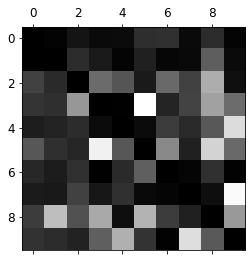

In [76]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
vz.save_fig("confusion_matrix_errors_plot", tight_layout=False)


### Многозначная классификация

In [77]:
# две метки
y_train_large = (y_train >= 7)     # является ли цифра большой? 7,8,9
y_train_odd = (y_train % 2 == 1)   # является ли нечетной
y_multilabel = np.c_[y_train_large, y_train_odd]
(y_train_large, y_train_odd, y_multilabel)

(array([False, False, False, ..., False, False, False]),
 array([False, False,  True, ...,  True, False,  True]),
 array([[False, False],
        [False, False],
        [False,  True],
        ...,
        [False,  True],
        [False, False],
        [False,  True]]))

In [78]:
knn_clf = KNeighborsClassifier()
knn_clf

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [80]:
%%time
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict(([some_digit]))

# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
# f1_score(y_multilabel, y_train_knn_pred, average="macro")

Wall time: 50.9 s


array([[ True,  True]])


### Многовыходовая классификация

In [82]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test
(X_train_mod, y_train_mod,   X_train_mod.shape, y_train_mod.shape)

(array([[59,  6, 66, ..., 96, 84, 40],
        [64, 66, 17, ..., 46, 56, 96],
        [ 1, 38, 74, ..., 77, 45, 47],
        ...,
        [34, 65, 72, ..., 24, 14, 77],
        [42, 54, 78, ..., 29, 78, 71],
        [24, 12, 23, ..., 93, 55, 40]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 (60000, 784),
 (60000, 784))

Saving figure noisy_digit_example_plot


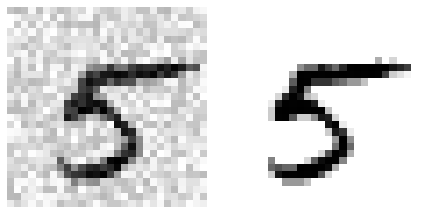

In [88]:
some_index = 5500
plt.subplot(121); vz.plot_digit(X_test_mod[some_index])
plt.subplot(122); vz.plot_digit(y_test_mod[some_index])
vz.save_fig("noisy_digit_example_plot")

Saving figure cleaned_digit_example_plot


(1, 784)

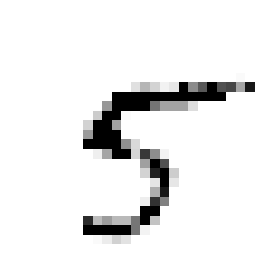

In [90]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
vz.plot_digit(clean_digit)
vz.save_fig("cleaned_digit_example_plot")
clean_digit.shape



## Визуализация